# DLT Quick Start

**DLT** stands for Damped Local Trend model, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

In this notebook we will show how to use Orbit DLT models with the US unemployment claims data and different gloabl trend options

**Note: Negative response values are not allowed in dlt model, due to the existence of the global trend term.**

In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta

from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

import warnings
warnings.filterwarnings('ignore')

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018. 
This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to be fitted as a multiplicative model.

In [6]:
# load data
df = load_iclaims()
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [7]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


### Train / Test Split

In [8]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

In [9]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## DLT Model

**DLT** stands for Damped Local Trend model,

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$\hat{y}_t=\mu_t + s_t + r_t $$
$$\mu_t=D(t) + l_{t-1} +  \theta{b_{t-1}}$$

with the update process as such 

$$g_t = D(t)$$
$$l_t = \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)l_{t-1}$$
$$b_t=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta{b_{t-1}}$$
$$s_{t+m} =  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t$$
$$r_t =  \Sigma_{j}\beta_j x_{jt}$$

There are a few choices of $D(t)$ as a global trend, such as linear, log-linear and logistic. Another feature of DLT is the regression component $r_t$. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, assume

$$\beta_j ~\sim \mathtt{Normal}(\mu_j, \sigma_j)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. There are more choices of priors for the regression component in the package.

In orbit, we have three different wrappers for DLT models, `DLTMAP`, `DLTAggregated` and  `DLTFull`

### DLTMAP

DLT model for MAP (Maximum a Posteriori) prediction

In [10]:
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [11]:
%%time
dlt.fit(df=train_df)

CPU times: user 130 ms, sys: 9.32 ms, total: 140 ms
Wall time: 403 ms


In [12]:
predicted_df = dlt.predict(df=test_df)

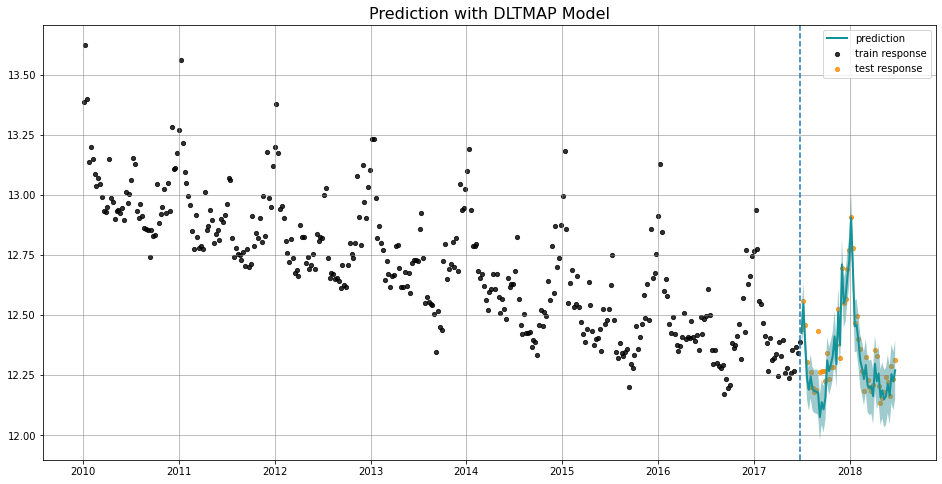

In [13]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df, title='Prediction with DLTMAP Model')

### DLTFull

LGT model for full prediction. In full prediction, the prediction occurs as a function of each parameter posterior sample, and the prediction results are aggregated after prediction. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified.

In [14]:
dlt = DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888
)

In [15]:
%%time
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 94 ms, sys: 114 ms, total: 208 ms
Wall time: 4.94 s


In [16]:
predicted_df = dlt.predict(df=test_df, store_prediction_array=True)

In [ ]:
dlt.pre

In [17]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.110832,12.236411,12.365385
48,2018-06-03,12.059123,12.178334,12.289549
49,2018-06-10,12.091117,12.275301,12.384388
50,2018-06-17,12.117888,12.241044,12.329424
51,2018-06-24,12.170938,12.299122,12.382156


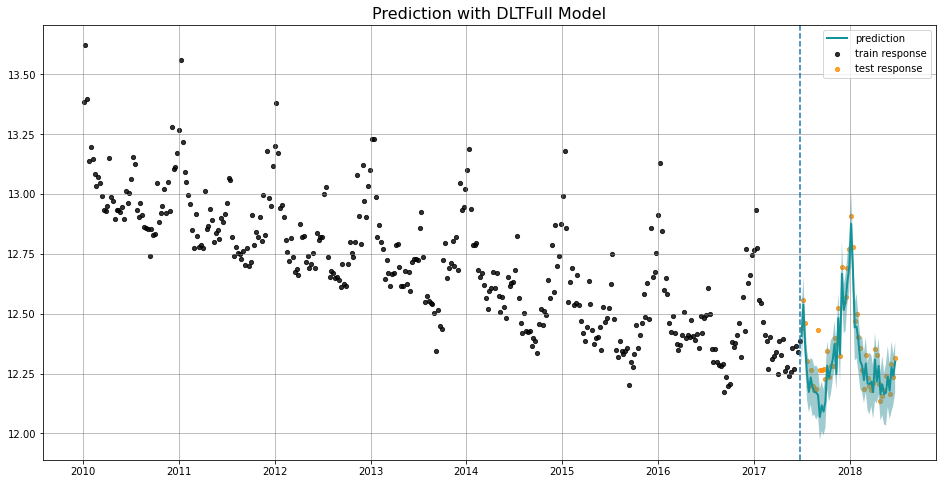

In [18]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, 
                    test_actual_df=test_df, title='Prediction with DLTFull Model')

### DLTAggregated

DLT model for aggregated posterior prediction. In aggregated prediction, the parameter posterior samples are reduced using `aggregate_method ({ 'mean', 'median' })` before performing a single prediction.

In [19]:
dlt = DLTAggregated(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888
)

In [20]:
%%time
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 88.7 ms, sys: 112 ms, total: 201 ms
Wall time: 5.01 s


In [21]:
predicted_df = dlt.predict(df=test_df)

In [22]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.119215,12.235614,12.348946
48,2018-06-03,12.057665,12.173141,12.288050
49,2018-06-10,12.150280,12.267156,12.382111
50,2018-06-17,12.119496,12.235667,12.354089
51,2018-06-24,12.166032,12.282595,12.398512


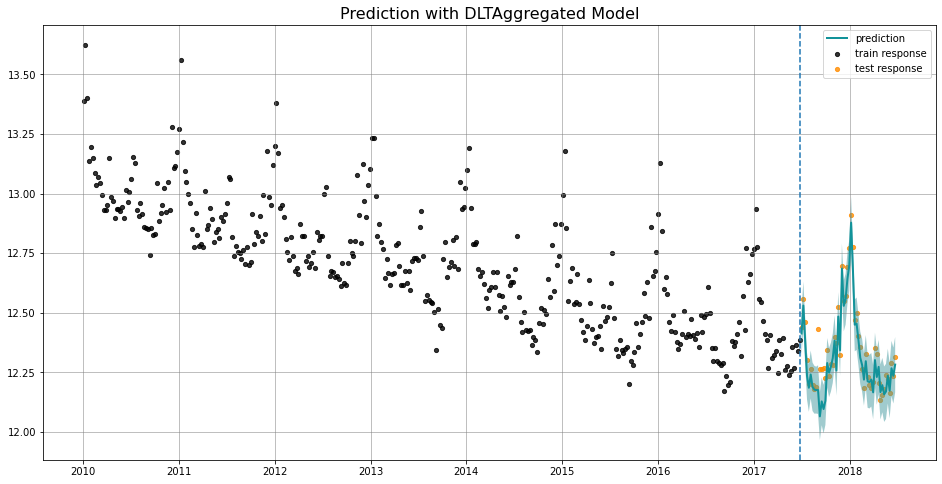

<AxesSubplot:title={'center':'Prediction with DLTAggregated Model'}>

In [23]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, 
                    test_actual_df=test_df, title='Prediction with DLTAggregated Model')

## DLT Model with Global Trend

The main differences between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

There are four options in modeling the `global trend` with the `global_trend_option` arguemnt:

1. `linear`
2. `loglinear`
3. `logistic`
4. `flat`

The behavior of these three options will depend on the condition of `is_multiplicative` as well.  Below, we only show cases with condition when `is_multiplicative` as `True` since it is the default.

### Data

Instead of splitting the data into train and test. We will the full data set to train and simulate the multiplicative prediction data in the following 4 years:

In [20]:
num_periods = 52 * 4
freq = 7
last_dt = (df[date_col].dt.to_pydatetime())[-1]
dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]
future_df = pd.DataFrame(dts, columns=[date_col])

### Linear Trend

In multiplicative model, the linear trend as default will be transformed as exponential growh/decay.

In [21]:
dlt = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888
)

In [22]:
%%time
dlt.fit(df)

CPU times: user 95.7 ms, sys: 7.13 ms, total: 103 ms
Wall time: 103 ms


In [23]:
predicted_df = dlt.predict(df=future_df, decompose=True)

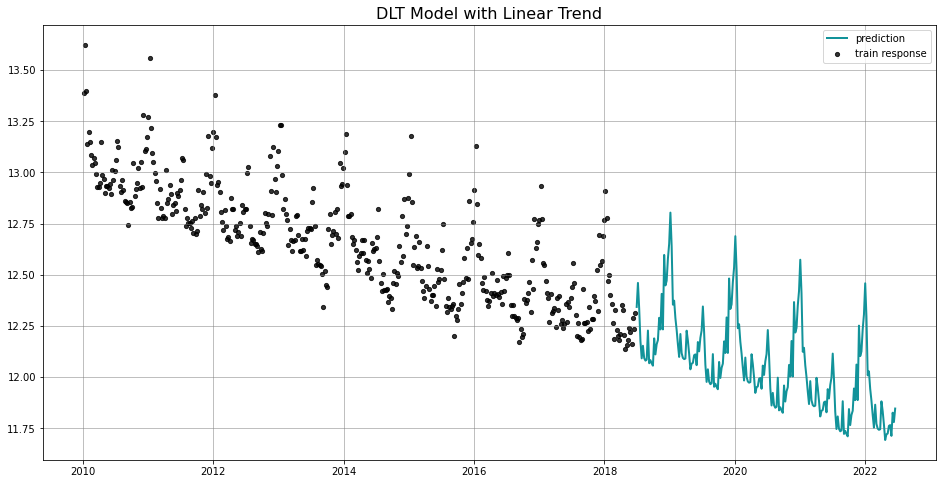

In [24]:
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
                        date_col=dlt.date_col, actual_col=dlt.response_col,
                        title='DLT Model with Linear Trend')

### Log-Linear Trend

For users who want to maintain linear trend assumption in the multiplicative model, they can switch to `loglinear` global trend.  

In [25]:
dlt_log = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='loglinear'
)

In [26]:
%%time
dlt_log.fit(df=df)

CPU times: user 132 ms, sys: 5.28 ms, total: 137 ms
Wall time: 138 ms


In [27]:
predicted_df_dlt_log = dlt_log.predict(df=future_df, decompose=True)

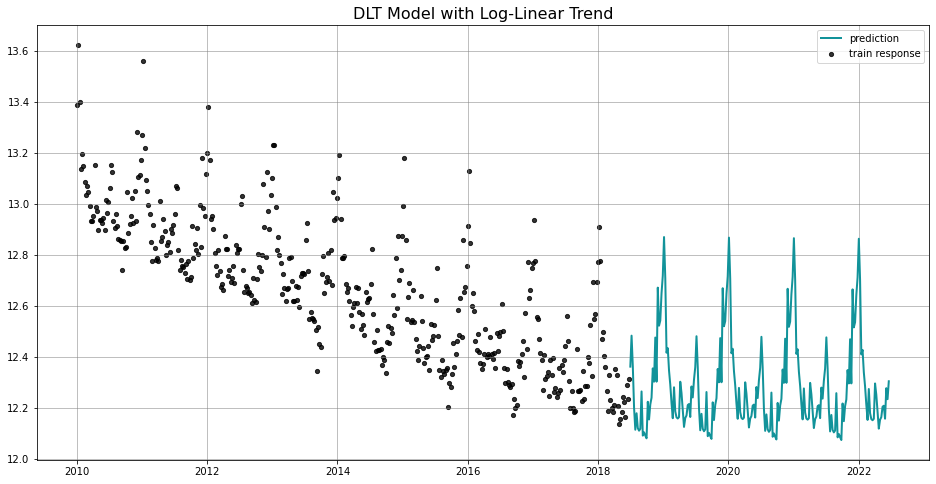

In [28]:
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_log, 
                        date_col=dlt_log.date_col, actual_col=dlt_log.response_col,
                        title='DLT Model with Log-Linear Trend')

### Logistic Trend

In case of modeling logistic growth/decay, user can switch to `logistic` in the `global_trend_option`. 

In [29]:
dlt_logit = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='logistic'
)

In [30]:
%%time
dlt_logit.fit(df=df)

CPU times: user 116 ms, sys: 6.87 ms, total: 123 ms
Wall time: 126 ms


In [31]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

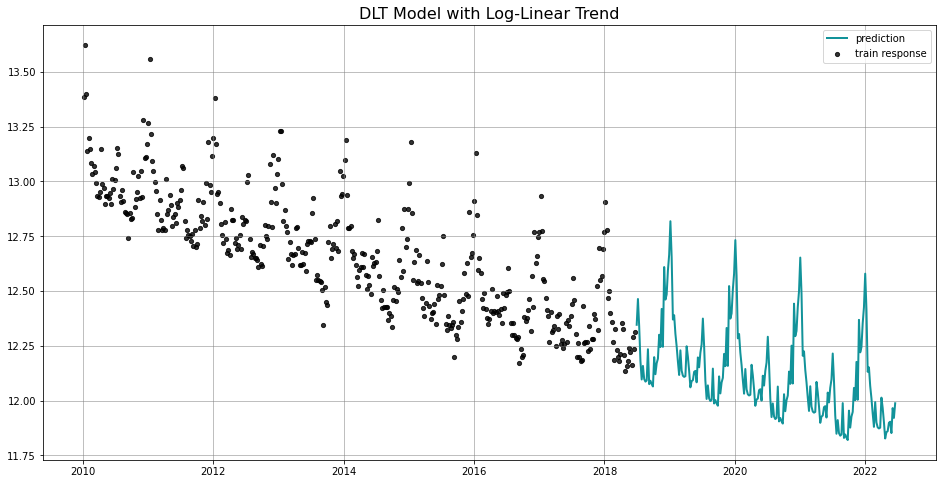

In [32]:
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                        date_col=dlt_log.date_col, actual_col=dlt_log.response_col,
                        title='DLT Model with Log-Linear Trend')

### Flat Trend

In [33]:
dlt_logit = DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    global_trend_option='flat'
)

In [34]:
%%time
dlt_logit.fit(df=df)

CPU times: user 84.9 ms, sys: 5.88 ms, total: 90.8 ms
Wall time: 91 ms


In [35]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

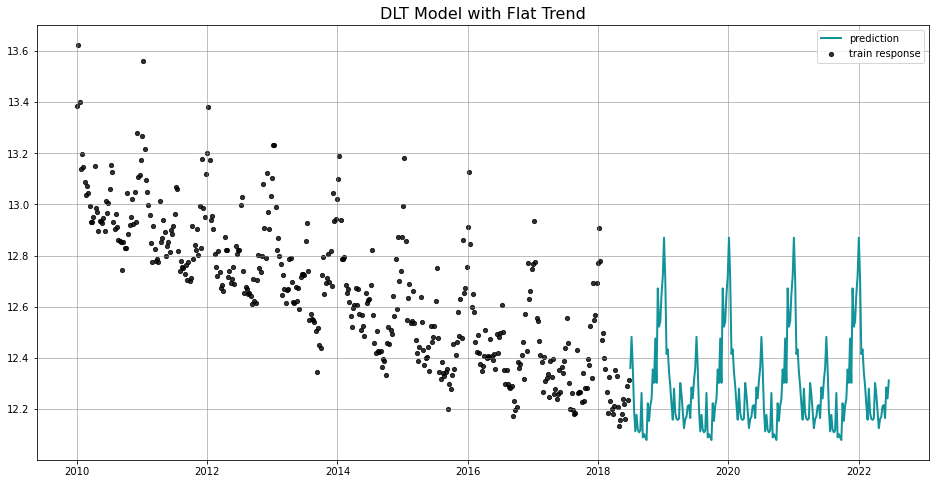

In [36]:
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df_dlt_logit, 
                        date_col=dlt_log.date_col, actual_col=dlt_log.response_col,
                        title='DLT Model with Flat Trend')

More details for each method are available in the docstrings and also here: https://uber.github.io/orbit/orbit.models.html#module-orbit.models.dlt